In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from simple_tritium_transport_model import ureg, quantity_to_activity, activity_to_quantity

from baby_run_5 import *

In [2]:
baby_model.run(7 * ureg.day)


/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:224: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:239: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [3]:
print(f"Transport:")
print(f"  mass transport coeff top: {baby_model.k_top:.2e~P}")
print(f"  mass transport coeff wall: {baby_model.k_wall:.2e~P}")

print("Source:")
print(f"  TBR: {baby_model.TBR:.2e~P}")
print(f"  neutron rate: {baby_model.neutron_rate:.2e~P}")
print(f"  neutron rate * TBR: {baby_model.neutron_rate * baby_model.TBR:.2e~P}")
print(f"  k_top/k_wall: {baby_model.k_top/baby_model.k_wall:.2f~P}")

print("Geometry:")
print(f"  volume: {baby_model.volume.to(ureg.cm**3):.2f~P}")
print(f"  top area: {baby_model.A_top.to(ureg.cm**2):.2f~P}")
print(f"  wall area: {baby_model.A_wall.to(ureg.cm**2):.2f~P}")

Transport:
  mass transport coeff top: 7.94×10⁻⁷ m/s
  mass transport coeff wall: 3.08×10⁻⁸ m/s
Source:
  TBR: 4.79×10⁻⁴ particle/n
  neutron rate: 3.72×10⁸ n/s
  neutron rate * TBR: 1.78×10⁵ particle/s
  k_top/k_wall: 25.79
Geometry:
  volume: 85.00 cm³
  top area: 13.80 cm²
  wall area: 100.82 cm²


In [4]:
def replace_water(sample_activity, time, replacement_times=None):
    sample_activity_changed = np.copy(sample_activity)
    times_changed = np.copy(time)

    if replacement_times is None:
        replacement_times = [
            i + 1 for i in range(baby_model.number_days.to(ureg.day).magnitude)
        ] * ureg.day
    else:
        replacement_times = sorted(replacement_times)

    for replacement_time in replacement_times:
        indices = np.where(times_changed > replacement_time)
        # before each irradiation, make the sample activity drop to zero
        sample_activity_changed[indices] -= sample_activity_changed[indices][0]

        # insert nan value to induce a line break in plots
        if indices[0].size > 0:
            first_index = indices[0][0]
            sample_activity_changed = np.insert(
                sample_activity_changed, first_index, np.nan * ureg.Bq
            )
            times_changed = np.insert(times_changed, first_index, np.nan * ureg.day)

    return sample_activity_changed, times_changed


In [5]:
COLLECTION_VOLUME = 10 * ureg.ml
LSC_SAMPLE_VOLUME = 10 * ureg.ml


def plot_model(
    model,
    top=True,
    walls=True,
    detection_limit=0.4 * ureg.Bq,
    irradiation=True,
    replace_vials=True,
    title=True,
    subtitle=True,
    linelabel=True,
):
    plt.gca().xaxis.set_units(ureg.day)
    plt.gca().yaxis.set_units(ureg.Bq)

    if title:
        plt.gcf().text(0.08, 0.97, "Sample activity", weight="bold", fontsize=15)
    if subtitle:
        subtitle_text = [
            f"TBR = {model.TBR.to(ureg.dimensionless):.2e~P}, salt volume {model.volume.to(ureg.ml):.0f~P}, neutron rate: {model.neutron_rate:.2e~P}, irradiation time: {model.exposure_time}",
            f"collection volume: {COLLECTION_VOLUME:.0f~P}, sample volume: {LSC_SAMPLE_VOLUME:.0f~P}",
        ]
        plt.gcf().text(0.08, 0.9, s="\n".join(subtitle_text), fontsize=6.5)

    if top:
        integrated_top = quantity_to_activity(model.integrated_release_top()).to(
            ureg.Bq
        )
        sample_activity_top = integrated_top / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME
        times = model.times
        if replace_vials:
            if replace_vials is True:
                replacement_times = None
            else:
                replacement_times = replace_vials
            sample_activity_top, times = replace_water(
                sample_activity_top, model.times, replacement_times=replacement_times
            )
        plt.plot(
            times.to(ureg.day),
            sample_activity_top,
            color="#023047",
            label="Top",
        )
    if walls:
        integrated_wall = quantity_to_activity(model.integrated_release_wall()).to(
            ureg.Bq
        )
        sample_activity_wall = integrated_wall / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME
        times = model.times
        if replace_vials:
            if replace_vials is True:
                replacement_times = None
            else:
                replacement_times = replace_vials
            sample_activity_wall, times = replace_water(
                sample_activity_wall, model.times, replacement_times=replacement_times
            )
        plt.plot(
            times.to(ureg.day),
            sample_activity_wall,
            color="tab:green",
            label="Walls",
        )

    if detection_limit:
        plt.axhline(y=detection_limit, color="tab:grey", linestyle="dashed")

    if irradiation:
        if irradiation is True:
            for day in range(model.number_days.to(ureg.day).magnitude):
                plt.axvspan(
                    0 * ureg.h + day * ureg.day,
                    model.exposure_time + day * ureg.day,
                    facecolor="#EF5B5B",
                    alpha=0.5,
                )
        else:
            for irr in irradiation:
                plt.axvspan(
                    irr[0].to(ureg.day),
                    irr[1].to(ureg.day),
                    facecolor="#EF5B5B",
                    alpha=0.5,
                )

    plt.xlim(left=0 * ureg.day)
    plt.ylim(bottom=0)
    # plt.yscale("log")
    if linelabel:
        labelLines(plt.gca().get_lines(), zorder=2.5)
    plt.gca().spines[["right", "top"]].set_visible(False)
    plt.grid(alpha=0.5)


/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:448: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:452: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)
/home/remidm/.local/lib/python3.10/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child1), but could not find a label for it.
  warnings.warn(


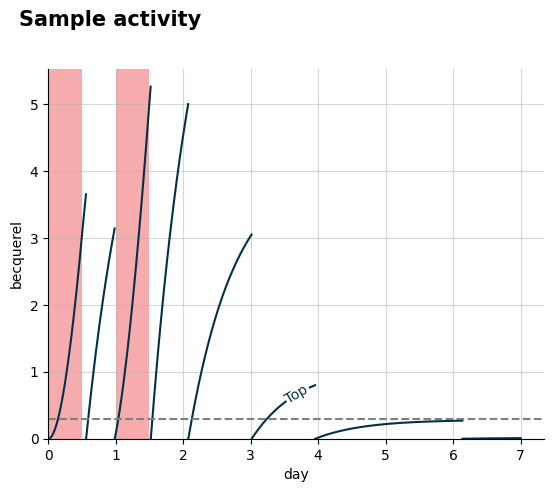

In [6]:
# time starts at 12/05 9:30 AM
# 12/06 9:30 AM = 24 hours
# 12/07 9:30 AM = 48 hours
replacement_times = [
    # 12/05 22:58
    0 * ureg.day + 13 * ureg.hour + 28 * ureg.minute,
    # 12/06 09:09
    0 * ureg.day + 23 * ureg.hour + 39 * ureg.minute,
    # 12/06 21:58 
    1 * ureg.day + 12 * ureg.hour + 28 * ureg.minute,
    # 12/07 11:19
    1 * ureg.day + 25 * ureg.hour + 49 * ureg.minute,
    # 12/08 09:53
    2 * ureg.day + 24 * ureg.hour + 23 * ureg.minute,
    # 12/09 08:28
    3 * ureg.day + 22 * ureg.hour + 58 * ureg.minute,
    # 12/11 12:48
    6 * ureg.day + 3 * ureg.hour + 18 * ureg.minute,
]

replacement_times = sorted(replacement_times)

avg_background = background

plot_model(
    baby_model,
    irradiation=baby_model.irradiations,
    replace_vials=replacement_times,
    walls=False,
    detection_limit=avg_background,
    subtitle=False,
)

[<Quantity(3.649, 'becquerel')>, <Quantity(7.475, 'becquerel')>, <Quantity(11.938, 'becquerel')>, <Quantity(16.961, 'becquerel')>, <Quantity(19.672, 'becquerel')>, <Quantity(20.677, 'becquerel')>, <Quantity(21.358, 'becquerel')>]


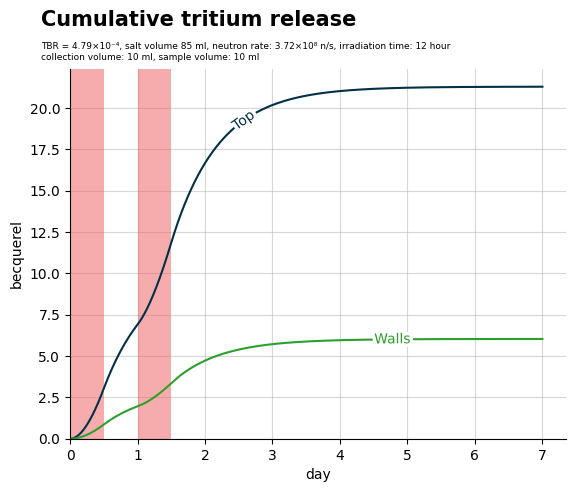

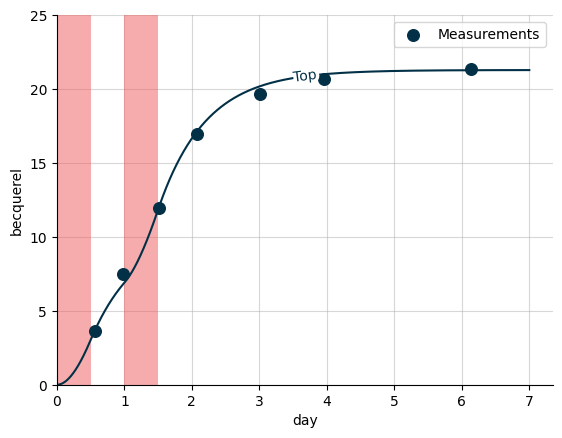

In [7]:
plot_model(
    model=baby_model,
    replace_vials=False,
    title=False,
    detection_limit=None,
    linelabel=True,
)
plt.gcf().text(0.08, 0.97, "Cumulative tritium release", weight="bold", fontsize=15)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_5/cumulative_tritium_release_no_exp.svg")

plt.figure()
plot_model(
    model=baby_model,
    replace_vials=False,
    title=False,
    subtitle=False,
    walls=False,
    detection_limit=None,
    linelabel=True,
)
sample_1 = vial_511 + vial_512 + vial_513 + vial_514
sample_2 = vial_521 + vial_522 + vial_523 + vial_524
sample_3 = vial_531 + vial_532 + vial_533 + vial_534
sample_4 = vial_541 + vial_542 + vial_543 + vial_544
sample_5 = vial_551 + vial_552 + vial_553 + vial_554
sample_6 = vial_561 + vial_562 + vial_563 + vial_564
sample_7 = vial_571 + vial_572 + vial_573 + vial_574

cumulative_1 = sample_1
cumulative_2 = sample_1 + sample_2
cumulative_3 = sample_1 + sample_2 + sample_3
cumulative_4 = sample_1 + sample_2 + sample_3 + sample_4
cumulative_5 = sample_1 + sample_2 + sample_3 + sample_4 + sample_5
cumulative_6 = (
    sample_1 + sample_2 + sample_3 + sample_4 + sample_5 + sample_6
)
cumulative_7 = (
    sample_1 + sample_2 + sample_3 + sample_4 + sample_5 + sample_6 + sample_7
)

cumulative_values = [cumulative_1, cumulative_2, cumulative_3, cumulative_4, cumulative_5, cumulative_6, cumulative_7]
print(cumulative_values)
s = plt.scatter(
    replacement_times,
    cumulative_values,
    s=70,
    label="Measurements",
    color="#023047"
)
plt.legend(handles=[s])
# plt.gcf().text(0.08, 0.97, "Cumulative tritium release", weight="bold", fontsize=15)
plt.gca().set_axisbelow(True)
plt.ylim(top=25 * ureg.Bq)
plt.savefig("baby_run_5/cumulative_tritium_release.svg")
plt.savefig("baby_run_5/cumulative_tritium_release.pdf")



[<Quantity(0.561111111, 'day')>, <Quantity(0.985416667, 'day')>, <Quantity(1.51944444, 'day')>, <Quantity(2.07569444, 'day')>, <Quantity(3.01597222, 'day')>, <Quantity(3.95694444, 'day')>, <Quantity(6.1375, 'day')>]


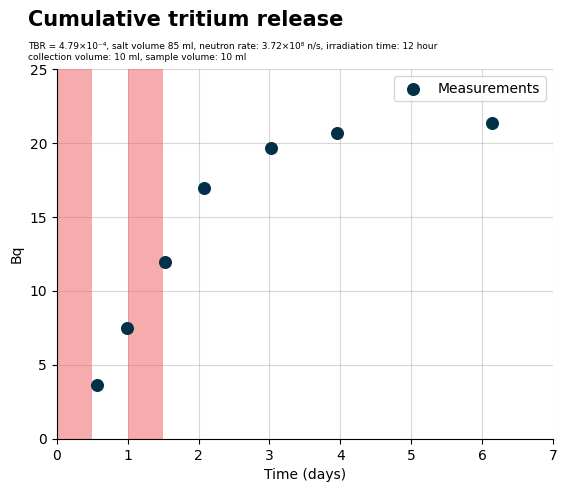

In [8]:
plt.figure()

# set x axis units to days
plt.gca().xaxis.set_units(ureg.day)

plot_model(
    model=baby_model,
    walls=False,
    top=False,
    replace_vials=False,
    title=False,
    detection_limit=None,
    linelabel=True,
)
print(replacement_times)
s = plt.scatter(
    replacement_times,
    cumulative_values,
    s=70,
    label="Measurements",
    color="#023047",
)
plt.legend(handles=[s])
plt.gcf().text(0.08, 0.97, "Cumulative tritium release", weight="bold", fontsize=15)
plt.gca().set_axisbelow(True)
plt.ylim(top=25 * ureg.Bq)
plt.xlim(right=7 * ureg.day)
plt.xlabel("Time (days)")
plt.ylabel("Bq")
plt.savefig('baby_run_5/cumulative_tritium_release_experimental_only.svg')

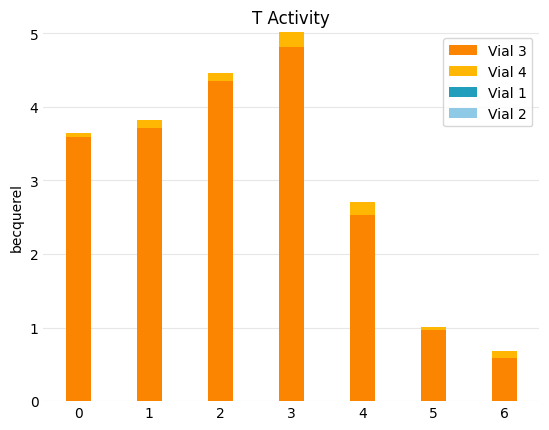

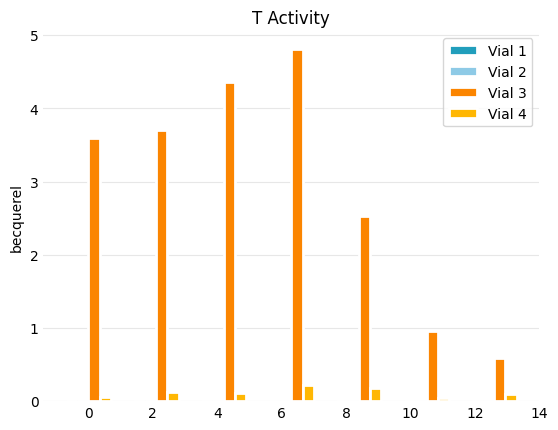

In [9]:
# Create the stacked bar plot
vial_1_vals = (
    np.array(
        [
            vial_511.magnitude,
            vial_521.magnitude,
            vial_531.magnitude,
            vial_541.magnitude,
            vial_551.magnitude,
            vial_561.magnitude,
            vial_571.magnitude,
        ]
    )
    * ureg.Bq
)

vial_2_vals = (
    np.array(
        [
            vial_512.magnitude,
            vial_522.magnitude,
            vial_532.magnitude,
            vial_542.magnitude,
            vial_552.magnitude,
            vial_562.magnitude,
            vial_572.magnitude,
        ]
    )
    * ureg.Bq
)

vial_3_vals = (
    np.array(
        [
            vial_513.magnitude,
            vial_523.magnitude,
            vial_533.magnitude,
            vial_543.magnitude,
            vial_553.magnitude,
            vial_563.magnitude,
            vial_573.magnitude,
        ]
    )
    * ureg.Bq
)

vial_5_vals = (
    np.array(
        [
            vial_514.magnitude,
            vial_524.magnitude,
            vial_534.magnitude,
            vial_544.magnitude,
            vial_554.magnitude,
            vial_564.magnitude,
            vial_574.magnitude,
        ]
    )
    * ureg.Bq
)

plt.figure()


def plot_bars(index=None, bar_width=0.35, stacked=True):
    if index is None:
        if stacked:
            index = np.arange(7)
        else:
            group_spacing = 1  # Adjust this value to control spacing between groups
            index = np.arange(7) * (group_spacing / 2 + 1) * bar_width * 4

    if stacked:
        vial_3_bar = plt.bar(
            index, vial_3_vals, bar_width, label="Vial 3", color="#FB8500",

        )
        vial_4_bar = plt.bar(
            index,
            vial_5_vals,
            bar_width,
            label="Vial 4",
            color="#FFB703",
            bottom=vial_3_vals,
        )
        vial_1_bar = plt.bar(
            index,
            vial_1_vals,
            bar_width,
            label="Vial 1",
            color="#219EBC",
            bottom=vial_3_vals + vial_5_vals,
        )
        vial_2_bar = plt.bar(
            index,
            vial_2_vals,
            bar_width,
            label="Vial 2",
            color="#8ECAE6",
            bottom=vial_3_vals + vial_5_vals + vial_1_vals,
        )
    else:
        vial_1_bar = plt.bar(
            index - 1.5 * bar_width,
            vial_1_vals,
            bar_width,
            linewidth=2,
            edgecolor="white",
            label="Vial 1",
            color="#219EBC",
        )
        vial_2_bar = plt.bar(
            index - 0.5 * bar_width,
            vial_2_vals,
            bar_width,
            linewidth=2,
            edgecolor="white",
            label="Vial 2",
            color="#8ECAE6",
        )
        vial_3_bar = plt.bar(
            index + 0.5 * bar_width,
            vial_3_vals,
            bar_width,
            linewidth=2,
            edgecolor="white",
            label="Vial 3",
            color="#FB8500",
        )
        vial_4_bar = plt.bar(
            index + 1.5 * bar_width,
            vial_5_vals,
            bar_width,
            linewidth=2,
            edgecolor="white",
            label="Vial 4",
            color="#FFB703",
        )

    return index


for stacked in [True, False]:
    index = plot_bars(stacked=stacked)
    # plt.xticks(index, ["Day 1", "Day 2", "Day 4"])
    plt.title("T Activity")
    plt.legend()
    plt.gca().spines[["right", "bottom", "top", "left"]].set_visible(False)
    plt.grid(True, axis="y", alpha=0.3)
    plt.gca().tick_params(axis="both", which="both", length=0)
    if stacked:
        plt.savefig("baby_run_5/LSC results_stacked.svg")
    else:
        plt.savefig("baby_run_5/LSC results.svg")
    plt.gca().set_axisbelow(True)
    plt.show()

/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:448: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:452: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)


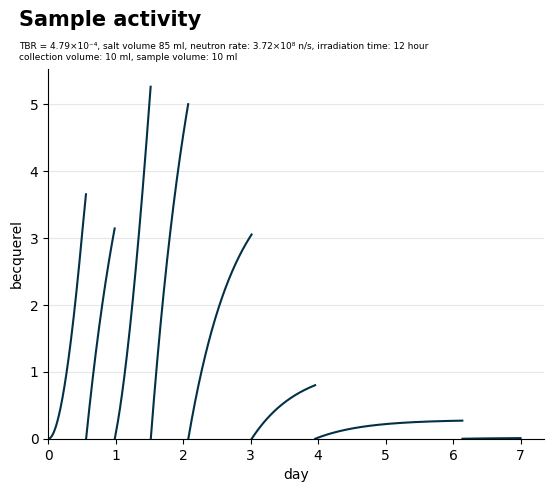

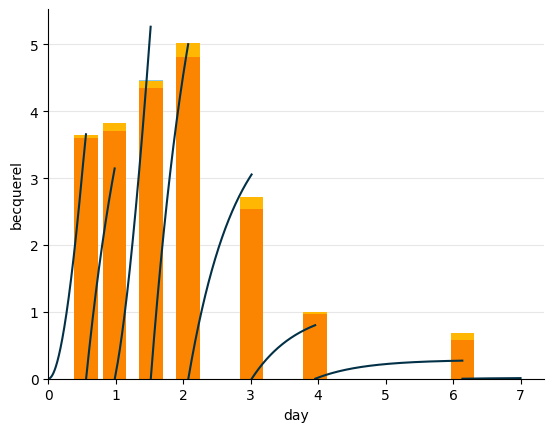

In [10]:
plt.figure()
plot_model(
    model=baby_model,
    replace_vials=replacement_times,
    walls=False,
    irradiation=False,
    detection_limit=None,
    linelabel=False,
)
plt.grid(False)
plt.grid(True, axis="y", alpha=0.3)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_5/sample_activity_no_exp.svg")

plt.figure()
plot_bars(index=[time.to(ureg.day) for time in replacement_times])
plot_model(
    model=baby_model,
    replace_vials=replacement_times,
    walls=False,
    irradiation=False,
    detection_limit=None,
    linelabel=False,
    title=False,
    subtitle=False,
)
plt.grid(False)
plt.grid(True, axis="y", alpha=0.3)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_5/sample_activity.svg")
plt.savefig("baby_run_5/sample_activity.pdf")


In [11]:
modification_factors = np.linspace(0.7, 1.3, 7)
models = []
for modif_factor in modification_factors:
    new_baby_model = Model(
        radius=baby_radius,
        height=baby_height,
        TBR=baby_model.TBR,
    )

    new_baby_model.k_top = baby_model.k_top * modif_factor
    new_baby_model.k_wall = baby_model.k_wall * modif_factor

    new_baby_model.number_days = baby_model.number_days
    new_baby_model.exposure_time = baby_model.exposure_time
    new_baby_model.neutron_rate = baby_model.neutron_rate
    new_baby_model.dt = baby_model.dt
    new_baby_model.run(7 * ureg.day)
    models.append(new_baby_model)


/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:224: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:239: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:448: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:452: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)
/home/remidm/.local/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:120: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  yi = np.asarray(yi)
/home/remidm/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:510: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = array(x, copy=self.copy)
/home/remidm/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:511: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = array(y, copy=self.copy)
/home/remid

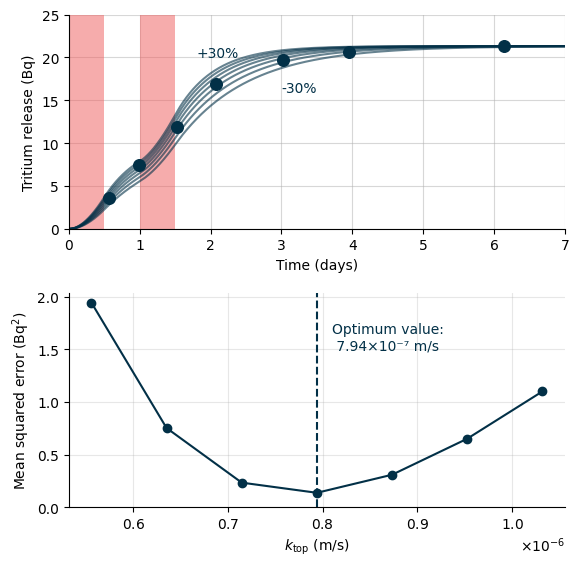

In [12]:
from scipy.interpolate import interp1d

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6.4))

plt.sca(axs[0])
model_to_error = {}
for i, new_baby_model in enumerate(models):
    if i == 0:
        plot_model(
            new_baby_model,
            detection_limit=None,
            linelabel=False,
            title=False,
            subtitle=False,
            walls=False,
            top=False,
            replace_vials=False,
            irradiation=True,
        )

    integrated_top = quantity_to_activity(new_baby_model.integrated_release_top()).to(
            ureg.Bq
        )
    plt.plot(
        new_baby_model.times.to(ureg.day),
        integrated_top,
        color="#023047",
        alpha=0.6
        # label="Top",
    )

plt.gca().set_axisbelow(True)
s = plt.scatter(
    replacement_times,
    cumulative_values,
    s=70,
    color="#023047",
)
plt.ylim(top=25 * ureg.Bq)
plt.xlim(right=7 * ureg.day)
plt.xlabel("Time (days)")
plt.ylabel(f"Tritium release (Bq)")

plt.annotate("+30%", xy=(1.8 * ureg.days, 20 * ureg.Bq), color="#023047")
plt.annotate("-30%", xy=(3.0 * ureg.days, 16 * ureg.Bq), color="#023047")

plt.sca(axs[1])

model_to_error = {}
for new_baby_model in models:
    integrated_top = quantity_to_activity(new_baby_model.integrated_release_top()).to(
            ureg.Bq
        )
    integrated_top = interp1d(new_baby_model.times.to(ureg.day), integrated_top)
    MSE = 0
    for i, sample_time in enumerate(replacement_times):
        computed_release = integrated_top(sample_time.to(ureg.day)) * ureg.Bq
        measured_release = cumulative_values[i]
        MSE += (computed_release - measured_release)**2
    MSE /= len(replacement_times)
    model_to_error[new_baby_model] = MSE

plt.plot(
    ureg.Quantity.from_list([model.k_top for model in list(model_to_error.keys())]),
    ureg.Quantity.from_list(list(model_to_error.values())),
    color="#023047",
    marker="o",
)
plt.ylim(bottom=0)
plt.grid(alpha=0.3)
plt.axvline(x=baby_model.k_top, color="#023047", linestyle="dashed")
# write optimum value
plt.annotate(
    f"Optimum value: \n {baby_model.k_top:.2e~P}",
    xy=(baby_model.k_top * 1.02, 1.5 * ureg.Bq**2),
    color="#023047",
)
plt.xlabel("$k_\mathrm{top}$ (m/s)")
plt.ylabel("Mean squared error (Bq$^2$)")
plt.gca().spines[["right", "top"]].set_visible(False)
plt.gca().xaxis.major.formatter._useMathText = True
plt.subplots_adjust(hspace=0.3)
plt.savefig("baby_run_5/optimisation_k_top.svg")
plt.savefig("baby_run_5/optimisation_k_top.pdf")

In [13]:
efficiency_1 = vial_513 / (vial_513 + vial_514)
efficiency_2 = vial_523 / (vial_523 + vial_524)
efficiency_3 = vial_533 / (vial_533 + vial_534)
efficiency_4 = vial_543 / (vial_543 + vial_544)
efficiency_5 = vial_553 / (vial_553 + vial_554)
efficiency_6 = vial_563 / (vial_563 + vial_564)
efficiency_7 = vial_573 / (vial_573 + vial_574)

average_efficiency = (
    efficiency_1
    + efficiency_2
    + efficiency_3
    + efficiency_4
    + efficiency_5
    + efficiency_6
    + efficiency_7
).magnitude / 7

nb_vials = 2
total_eff = 1 - (1 - average_efficiency) ** nb_vials

print(f"Efficiency of 1 vial: {average_efficiency:.2%}")
print(f"Efficiency of {nb_vials} vials: {total_eff:.2%}")



Efficiency of 1 vial: 94.81%
Efficiency of 2 vials: 99.73%


/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:448: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:452: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)


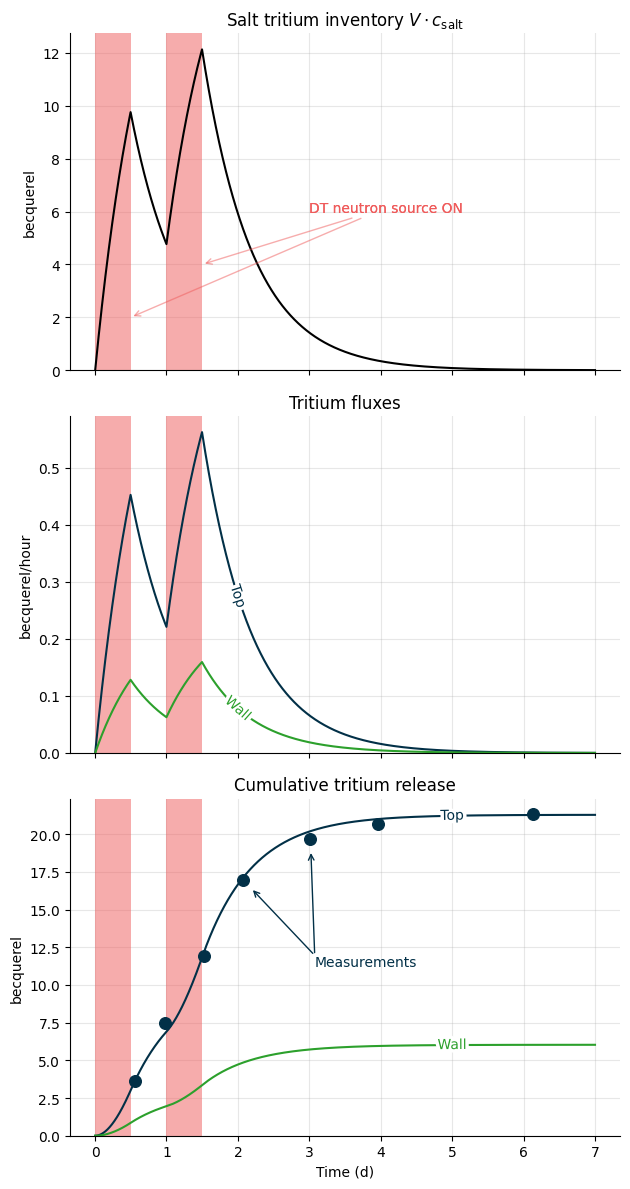

In [14]:
time = baby_model.times.to(ureg.day)

fig, (ax_inv, ax_fluxes, ax_cumul) = plt.subplots(3, 1, sharex=True, figsize=(6.4, 12))
plt.sca(ax_inv)
plt.title("Salt tritium inventory $V \cdot c_\mathrm{salt}$")
plt.plot(
    time,
    quantity_to_activity(baby_model.concentrations * baby_model.volume).to(ureg.Bq),
    color="black",
)

plt.sca(ax_fluxes)
plt.title("Tritium fluxes")
release_top = quantity_to_activity(baby_model.Q_top(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_top = release_top.to(ureg.Bq * ureg.h**-1)
release_walls = quantity_to_activity(baby_model.Q_wall(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_walls = release_walls.to(ureg.Bq * ureg.h**-1)
plt.plot(time, release_top, label="Top", color="#023047")
plt.plot(
    time,
    release_walls,
    label="Wall",
    color="tab:green",
)

plt.sca(ax_cumul)
plt.title("Cumulative tritium release")
integrated_top = quantity_to_activity(baby_model.integrated_release_top()).to(ureg.Bq)
integrated_wall = quantity_to_activity(baby_model.integrated_release_wall()).to(ureg.Bq)

plt.plot(time, integrated_top, label="Top", color="#023047")
plt.plot(
    time,
    integrated_wall,
    label="Wall",
    color="tab:green",
)
plt.xlabel(f"Time ({time.units:~P})")



for ax in [ax_inv, ax_fluxes, ax_cumul]:
    ax.set_ylim(bottom=0)
    ax.spines[["right", "top"]].set_visible(False)
    ax.grid(alpha=0.3)
    ax.set_axisbelow(True)

    for day in range(baby_model.number_days.to(ureg.day).magnitude):
        ax.axvspan(
            0 * ureg.h + day * ureg.day,
            baby_model.exposure_time + day * ureg.day,
            facecolor="#EF5B5B",
            alpha=0.5,
        )
s = plt.scatter(
    replacement_times,
    cumulative_values,
    s=70,
    label="Measurements",
    color="#023047",
)
labelLines(ax_fluxes.get_lines(), zorder=2.5, xvals=(2, 2))
labelLines(ax_cumul.get_lines(), zorder=2.5, xvals=(5, 5))

ax_inv.annotate(
    "DT neutron source ON",
    xy=(1.5 * ureg.day, 4 * ureg.Bq),
    xytext=(3 * ureg.days, 6 * ureg.Bq),
    color="#EF5B5B",
    arrowprops=dict(arrowstyle='->', color="#EF5B5B", alpha=0.5),
)
ax_inv.annotate(
    "DT neutron source ON",
    xy=(0.5 * ureg.day, 2 * ureg.Bq),
    xytext=(3 * ureg.days, 6 * ureg.Bq),
    color="#EF5B5B",
    arrowprops=dict(arrowstyle='->', color="#EF5B5B", alpha=0.5),
)

ax_cumul.annotate(
    "",
    xy=(replacement_times[3], cumulative_values[3]),
    xytext=(replacement_times[3] + 1 * ureg.day, cumulative_values[3] - 5 * ureg.Bq),
    arrowprops=dict(arrowstyle='->', color="#023047", shrinkB=10),
)
ax_cumul.annotate(
    "",
    xy=(replacement_times[4], cumulative_values[4]),
    xytext=(replacement_times[3] + 1 * ureg.day, cumulative_values[3] - 5 * ureg.Bq),
    arrowprops=dict(arrowstyle='->', color="#023047", shrinkB=10),
)
ax_cumul.annotate(
    "Measurements",
    color="#023047",
    xy=(replacement_times[4], cumulative_values[4]),
    xytext=(replacement_times[3] + 1 * ureg.day, cumulative_values[3] - 5 * ureg.Bq),
    va = "top", ha="left"
)

plt.tight_layout()
plt.savefig("baby_run_5/basic_model_results.svg")
plt.savefig("baby_run_5/basic_model_results.pdf")
plt.show()

In [15]:
import h_transport_materials as htm
print(f"HTM version {htm.__version__}")
flibe_diffusivities = htm.diffusivities.filter(material=[htm.FLIBE, htm.FLINAK])
temp = htm.ureg.Quantity(700, htm.ureg.degC).to(htm.ureg.K)
L = baby_model.height
sh_numbers = []
for flibe_D in flibe_diffusivities:
    if flibe_D.range[0] <= temp <= flibe_D.range[1]:
        D = flibe_D.value(temp).magnitude * ureg.m**2 * ureg.s**-1
        sherwood_nb = baby_model.k_top/(D /L)
        sh_numbers.append(sherwood_nb.to(ureg.dimensionless).magnitude)
        print(f"{sherwood_nb.to(ureg.dimensionless):.1f}")

print(f"Average Sh number: {np.mean(sh_numbers):.1f}")
print(f"Median Sh number: {np.median(sh_numbers):.1f}")

HTM version 0.14
4.4 dimensionless
16.0 dimensionless
0.6 dimensionless
1.2 dimensionless
9.4 dimensionless
6.0 dimensionless
15.9 dimensionless
7.6 dimensionless
Average Sh number: 7.7
Median Sh number: 6.8


In [16]:
S = (baby_model.neutron_rate * baby_model.TBR).to(ureg.particle / ureg.h)
print(
    f"Source of tritium (modelled): \n  {S:.2e~P} \n  {quantity_to_activity(S).to(ureg.Bq / ureg.hour):.2f~P}"
)

irradiation_time = sum([irr[1] - irr[0] for irr in baby_model.irradiations])
S_measured = (
    activity_to_quantity(cumulative_values[-1]).to(ureg.particle) / irradiation_time
)
print(
    f"Source of tritium (measured top only): \n  {S_measured:.2e~P} \n  {quantity_to_activity(S_measured).to(ureg.Bq / ureg.hour):.2f~P}"
)

S_measured = (
    activity_to_quantity(cumulative_values[-1] + integrated_wall[-1]).to(ureg.particle)
    / irradiation_time
)
print(
    f"Source of tritium (measured + assumption): \n  {S_measured:.2e~P} \n  {quantity_to_activity(S_measured).to(ureg.Bq / ureg.hour):.2f~P}"
)



Source of tritium (modelled): 
  6.41×10⁸ particle/h 
  1.15 Bq/h
Source of tritium (measured top only): 
  4.98×10⁸ particle/h 
  0.89 Bq/h
Source of tritium (measured + assumption): 
  6.38×10⁸ particle/h 
  1.14 Bq/h
